In [251]:
%env TF_FORCE_UNIFIED_MEMORY=1

env: TF_FORCE_UNIFIED_MEMORY=1


In [252]:
import unlimtd_f
import time
from jax import random, jit, pmap, value_and_grad, lax, vmap
import dataset_multi_infinite
import dataset_lines_infinite
import test
import plots
import ntk
import nll
import jax
from jax import numpy as np
import pickle
import models
import utils

In [253]:
seed = 1655235988902897757
print(seed)

1655235988902897757


## Network :

In [322]:
def nll(kernel_self, x_a, y_a, maddox_noise):
    """
    Computes the NLL of this data (one task only) wrt the kernel
    x_a is a (batch_size, input_dims) array (! has lost n_tasks)
    y_a is a (batch_size, reg_dim) array (! has lost n_tasks)
    """
    print(f"x_a : {x_a.shape}")
    cov_a_a = kernel_self(x_a)
    K = cov_a_a.shape[0]
    print(f"cov_a_a : {cov_a_a.shape}")
    cov_a_a = cov_a_a + maddox_noise ** 2 * np.eye(K)
    # print(f"cov_a_a : {cov_a_a.shape}")
    
    # prior mean is 0
    # print(f"y_a : {y_a.shape}")
    y_a = np.reshape(y_a, (-1))
    # print(f"y_a : {y_a.shape}")

    L = jax.scipy.linalg.cho_factor(cov_a_a)
    alpha = jax.scipy.linalg.cho_solve(L, y_a)
    return 0.5 * (y_a).T @ alpha + np.sum(np.log(np.diag(L[0]))) + 0.5 * K * np.log(2 * np.pi)


In [255]:
def nll_batch_one_kernel(kernel_self, x_a, y_a, maddox_noise):
    """
    NLL for a batch of tasks, when there is only one kernel (singGP)
    x_a is (n_tasks, batch_size, input_dims) (input_dims are (128, 128, 1) for vision, (1,) for toy problems)
    y_a is (n_tasks, batch_size, reg_dim)
    """
    def f(carry, task_data):
        x_a, y_a = task_data
        loss_here = nll(kernel_self, x_a, y_a, maddox_noise)
        return None, loss_here

    _, losses = lax.scan(f, None, (x_a, y_a))

    return np.array(losses)

In [320]:
def inner_product(x1, x2, theta):
    return np.dot(x1, x2)

def RBF_kernel(x1, x2, theta):
    l = theta
    # Now x1 and x2 are compatible for broadcasting
    # Compute squared Euclidean distance
    squared_diff = (x1 - x2) ** 2 / (2*l**2)
    return np.exp(-np.mean(squared_diff, axis=-1))

def CosSim_kernel(x1, x2, theta):
    # print(f"x1 : {x1.shape}, x2 : {x2.shape}")
    normalized_factor = np.linalg.norm(x1)*np.linalg.norm(x2)
    return theta * np.dot(x1,x2)/normalized_factor

def pseudo_polynomial_kernel(x1, x2, theta):
    # print(f"x1 : {x1.shape}, x2 : {x2.shape}")
    c = theta
    normalized_factor = np.linalg.norm(x1)*np.linalg.norm(x2)
    return (np.dot(x1,x2)/normalized_factor + c)**2

def polynomial_kernel(x1, x2, theta):
    # print(f"x1 : {x1.shape}, x2 : {x2.shape}")
    c = theta
    return (np.dot(x1,x2) + c)**2

Q = 4

def spectral_mixture_kernel(x1, x2, theta):
    """
    Compute the Spectral Mixture (SM) kernel between arrays x and xp.

    Parameters:
    - x, xp: Arrays of shape (n_samples, 1) or similar (input points for the kernel).
    - weights: Array of shape (Q,) where Q is the number of mixture components (mixture weights).
    - means: Array of shape (Q,) (mean frequencies of the components).
    - variances: Array of shape (Q,) (variances of the components).
    - Q: int, number of spectral mixture components.

    Returns:
    - Kernel matrix of shape (n_samples_x, n_samples_xp).
    """
    weights, periodes, length_scale = theta
    kernel = 0
    sqr_dist = np.sum((x1 - x2)**2, axis=-1)
    for q in range(Q):
        # Squared exponential decay term
        exp_decay = np.exp(-2 * np.pi**2 * length_scale[q] * sqr_dist)
        
        # Cosine term
        cos_term = np.cos(2 * np.pi * periodes[q] * np.sqrt(sqr_dist))
        
        # Combine terms and add to the kernel matrix
        kernel += weights[q] * exp_decay * cos_term
    
    return kernel

# Apply vmap to vectorize kernel function over pairs of inputs
# vectorized_kernel = vmap(kernel, in_axes=(0,0, None))
kernel = spectral_mixture_kernel
vectorized_kernel = vmap(vmap(kernel, in_axes=(None, 0, None)), in_axes=(0, None, None))


def kernel_matrix(x1, x2, theta):
    matrix = vectorized_kernel(x1, x2, theta)
    # For matern_kernel
    # matrix[np.isnan(matrix)] = sigma**2
    return matrix.squeeze()

In [304]:
from functools import partial

def get_kernel_identity_cov(part_apply_fn, current_params, theta, current_batch_stats):
    """
    Returns the kernel in case of an identity covariance matrix (JJ^\top)
    Also returns the jacobian J
    """
    def kernel(x1, x2):
        # print(f"part_apply_fn(x1) : {part_apply_fn(x1).shape}, part_apply_fn(x1) : {part_apply_fn(x1).shape}")
        return kernel_matrix(part_apply_fn(x1), part_apply_fn(x2), theta)

    def kernel_self(x1):
        # print(f"x1 : {x1.shape}")
        # print(f"part_apply_fn(x1) : {part_apply_fn(x1).shape}")
        f1 = part_apply_fn(x1)
        return kernel_matrix(f1, f1, theta)

    return kernel, kernel_self

In [305]:
def nll_batch_average_identity_cov(current_params, apply_fn, theta, current_batch_stats, x_a, y_a, maddox_noise):
    part_apply_fn = (partial(apply_fn, current_params, current_batch_stats))
    _, kernel_self = get_kernel_identity_cov(part_apply_fn, current_params, theta, current_batch_stats)
    
    return np.mean(nll_batch_one_kernel(kernel_self, x_a, y_a, maddox_noise))

In [306]:
def pmapable_loss_identity_cov(current_state, x_a, y_a, maddox_noise):
    # we can't pass current_state because we have to explicitely show the variable
    loss, (gradients_p, gradients_t) = value_and_grad(nll_batch_average_identity_cov, argnums = (0, 2) )(current_state.params,
                                                              current_state.apply_fn,
                                                              current_state.theta,
                                                              current_state.batch_stats,
                                                              x_a,
                                                              y_a,
                                                              maddox_noise)
    
    return loss, (gradients_p, gradients_t)

In [307]:
@jit
def batch_stats_updater(current_state, x_a):
    # shape of x_a is (n_tasks, batch_size, inputs_dims...)
    
    batch_stats = current_state.batch_stats
    
    def f(old_batch_stats, _x_a):
        # shape of _x_a is (batch_size, input_dims)
        _, mutated_vars = current_state.apply_fn_raw({"params":current_state.params,
                                                      "batch_stats": old_batch_stats},
                                                     _x_a,
                                                     mutable=["batch_stats"])
        
        new_batch_stats = mutated_vars["batch_stats"]
        return new_batch_stats, None

    batch_stats = dict(batch_stats)
    # print(type(batch_stats))
    batch_stats, _ = lax.scan(f, batch_stats, x_a)
    return batch_stats

In [308]:
@jit
def grad_applier_identity_cov(current_state, gradients_p, gradients_t, new_batch_stats):
    return current_state.apply_gradients(grads_params=gradients_p, grads_theta=gradients_t, new_batch_stats=new_batch_stats)

In [309]:
def step_identity_cov(key, current_state, n_tasks, K, data_noise, maddox_noise, n_devices, get_train_batch_fn):
    # Draw the samples for this step, and split it to prepare for pmap (jit'd)
    x_a, y_a, x_a_div, y_a_div = get_train_batch_fn(key, n_tasks, K, data_noise, n_devices)
    
    # Compute loss and gradient through gpu parallelization
    unaveraged_losses, (unaveraged_gradients_p, unaveraged_gradients_t) = pmap(pmapable_loss_identity_cov,
                             in_axes=(None, 0, 0, None),
                             static_broadcasted_argnums=(3)
                            )(current_state, x_a_div, y_a_div, maddox_noise)
    
    current_loss = np.mean(unaveraged_losses)
    current_gradients_p = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_p)
    current_gradients_t = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_t)
    
    # Update batch_stats "manually" (jit'd)
    new_batch_stats = batch_stats_updater(current_state, x_a)
    
    # Update state (parameters and optimizer)
    current_state = grad_applier_identity_cov(current_state, current_gradients_p, current_gradients_t, new_batch_stats)
    
    return current_state, current_loss

## Unlimitd f training

In [310]:
def get_kernel_and_jac_lowdim_cov(apply_fn, current_params, theta, current_scale, current_batch_stats, proj):
    """
    Returns the kernel in case of a low-dimensional covariance matrix (J P^\top s P J^\top)
    Also returns the jacobian J
    """

    jacobian = ntk.get_jacobian(apply_fn, current_params, current_batch_stats)

    def kernel(x1, x2):
        A1 = np.linalg.multi_dot([jacobian(x1), proj.T, np.diag(current_scale)])
        A2 = np.linalg.multi_dot([jacobian(x2), proj.T, np.diag(current_scale)])
        return kernel_matrix(A1, A2, theta)

    def kernel_self(x1):
        A1 = np.linalg.multi_dot([jacobian(x1), proj.T, np.diag(current_scale)])
        return kernel_matrix(A1, A1, theta)

    return kernel, kernel_self, jacobian

In [311]:
def nll_batch_average_lowdim_cov_singGP(current_params, current_scale, apply_fn, theta, current_batch_stats, proj, x_a, y_a, maddox_noise):
    _, kernel_self, jacobian = get_kernel_and_jac_lowdim_cov(apply_fn, current_params, theta, current_scale, current_batch_stats, proj)
    part_apply_fn = (partial(apply_fn, current_params, current_batch_stats))
    
    return np.mean(nll_batch_one_kernel(kernel_self, part_apply_fn, x_a, y_a, maddox_noise, jacobian))

In [312]:
def pmapable_loss_lowdim_cov_singGP(current_state, x_a, y_a, maddox_noise):
    # we can't pass current_state because we have to explicitely show the variable
    loss, (gradients_p, gradients_s, gradients_t) = value_and_grad(nll_batch_average_lowdim_cov_singGP, argnums = (0, 1, 3) )(current_state.params,
                                                              current_state.scale,
                                                              current_state.apply_fn,
                                                              current_state.theta,
                                                              current_state.batch_stats,
                                                              current_state.proj,
                                                              x_a,
                                                              y_a,
                                                              maddox_noise)
    
    return loss, (gradients_p, gradients_s, gradients_t)

In [313]:
@jit
def grad_applier_lowdim_cov_singGP(current_state, gradients_p, gradients_s, gradients_t, new_batch_stats):
    return current_state.apply_gradients(grads_params=gradients_p, grads_scale=gradients_s, grads_theta=gradients_t, new_batch_stats=new_batch_stats)

def step_lowdim_cov_singGP(key, current_state, n_tasks, K, data_noise, maddox_noise, n_devices, get_train_batch_fn):
    # Draw the samples for this step, and split it to prepare for pmap (jit'd)
    x_a, y_a, x_a_div, y_a_div = get_train_batch_fn(key, n_tasks, K, data_noise, n_devices)
    
    # Compute loss and gradient through gpu parallelization
    unaveraged_losses, (unaveraged_gradients_p, unaveraged_gradients_s, unaveraged_gradients_t) = pmap(pmapable_loss_lowdim_cov_singGP,
                             in_axes=(None, 0, 0, None),
                             static_broadcasted_argnums=(3)
                            )(current_state, x_a_div, y_a_div, maddox_noise)
    
    current_loss = np.mean(unaveraged_losses)
    current_gradients_p = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_p)
    current_gradients_s = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_s)
    current_gradients_t = jax.tree_map(lambda array: np.mean(array, axis=0), unaveraged_gradients_t)
    
    # Update batch_stats "manually" (jit'd)
    new_batch_stats = batch_stats_updater(current_state, x_a)
    
    # Update state (parameters and optimizer)
    current_state = grad_applier_lowdim_cov_singGP(current_state, current_gradients_p, current_gradients_s, current_gradients_t, new_batch_stats)
    
    return current_state, current_loss

In [314]:
def train_and_eval(key, step, n_epochs, state, n_tasks, K, data_noise, maddox_noise, get_train_batch_fn, eval_during_training_fn):
    """
    Available step functions:
    * step_identity_cov
    * step_lowdim_cov_singGP
    * step_lowdim_cov_mixture

    Available get_train_batch_fn functions:
    * dataset_sines_infinite.get_training_batch
    * dataset_sines_finite.get_training_batch
    * dataset_lines_infinite.get_training_batch
    * dataset_multi_infinite.get_training_batch
    * dataset_shapenet1d.get_training_batch
    
    """
    n_devices = jax.local_device_count()

    print("Starting training with:")
    print(f"-n_epochs={n_epochs}")
    print(f"-n_tasks={n_tasks}")
    print(f"-K={K}")
    print(f"-data_noise={data_noise}")
    print(f"-maddox_noise={maddox_noise}")

    losses = []
    evals = []
    theta_list = []
    t = time.time_ns()

    for epoch_index in range(n_epochs):
        key, subkey = random.split(key)
        state, current_loss = step(subkey, state, n_tasks, K, data_noise, maddox_noise, n_devices, get_train_batch_fn)

        if(np.isnan(current_loss)):
            print("Nan, aborting")
            break
        
        losses.append(current_loss)

        if epoch_index % 10 == 0:
            print(f"{epoch_index}  | {current_loss:.4f} ({(time.time_ns() - t)/ 10**9:.4f} s)")
        t = time.time_ns()

        if epoch_index % 200 == 0:
            key, subkey = random.split(key)
            theta_list.append(state.theta)
            current_eval = eval_during_training_fn(subkey, state)
            evals.append( current_eval )
            print(f"Eval: {current_eval}")
    print("Completed training")

    return state, losses, evals

In [315]:
from typing import Any, Callable

from flax import core
from flax import struct
from jax import numpy as np
import optax

#Train state for the identity covariance training (UNLIMTD-I, or the first part of UNLIMTD-F)

class TrainStateIdentityCovariance(struct.PyTreeNode):
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    apply_fn_raw: Callable = struct.field(pytree_node=False)
    params: core.FrozenDict[str, Any]
    tx_params: optax.GradientTransformation = struct.field(pytree_node=False)
    theta: np.ndarray
    tx_theta: optax.GradientTransformation = struct.field(pytree_node=False)
    batch_stats: core.FrozenDict[str, Any]
    opt_state_params: optax.OptState
    opt_state_theta: optax.OptState
    
    def apply_gradients(self, *, grads_params, new_batch_stats, grads_theta, **kwargs):
        """
        Updates both the params and the scaling matrix
        Also requires new_batch_stats to keep track of what has been seen by the network
        """

        # params part
        updates_params, new_opt_state_params = self.tx_params.update(grads_params, self.opt_state_params, self.params)
        new_params = optax.apply_updates(self.params, updates_params)

        # theta part
        updates_theta, new_opt_state_theta = self.tx_theta.update(grads_theta, self.opt_state_theta, self.theta)
        new_theta = optax.apply_updates(self.theta, updates_theta)

        return self.replace(
            step=self.step + 1,
            params=new_params,
            opt_state_params=new_opt_state_params,
            theta=new_theta,
            opt_state_theta=new_opt_state_theta,
            batch_stats=new_batch_stats,
            **kwargs,
        )


    @classmethod
    def create(cls, *, apply_fn, apply_fn_raw, params, theta, tx_params, tx_theta, batch_stats, **kwargs):
        opt_state_params = tx_params.init(params)
        opt_state_theta = tx_theta.init(theta)
        return cls(
            step=0,
            apply_fn=apply_fn,
            apply_fn_raw=apply_fn_raw,
            params=params,
            theta=theta,
            tx_params=tx_params,
            tx_theta=tx_theta,
            batch_stats=batch_stats,
            opt_state_params=opt_state_params,
            opt_state_theta=opt_state_theta,
            **kwargs,
        )

In [316]:
class TrainStateLowDimCovSingGP(struct.PyTreeNode):
    step: int
    apply_fn: Callable = struct.field(pytree_node=False)
    apply_fn_raw: Callable = struct.field(pytree_node=False)
    params: core.FrozenDict[str, Any]
    scale: np.ndarray
    theta: np.ndarray
    tx_params: optax.GradientTransformation = struct.field(pytree_node=False)
    tx_scale: optax.GradientTransformation = struct.field(pytree_node=False)
    tx_theta: optax.GradientTransformation = struct.field(pytree_node=False)
    batch_stats: core.FrozenDict[str, Any]
    opt_state_params: optax.OptState
    opt_state_scale: optax.OptState
    opt_state_theta: optax.OptState
    proj: np.ndarray
    
    def apply_gradients(self, *, grads_params, grads_theta, grads_scale, new_batch_stats, **kwargs):
        """
        Updates both the params and the scaling matrix
        Also requires new_batch_stats to keep track of what has been seen by the network
        """

        # params part
        updates_params, new_opt_state_params = self.tx_params.update(grads_params, self.opt_state_params, self.params)
        new_params = optax.apply_updates(self.params, updates_params)

        # scaling matrix part
        updates_scale, new_opt_state_scale = self.tx_scale.update(grads_scale, self.opt_state_scale, self.scale)
        new_scale = optax.apply_updates(self.scale, updates_scale)

        # theta part
        updates_theta, new_opt_state_theta = self.tx_theta.update(grads_theta, self.opt_state_theta, self.theta)
        new_theta = optax.apply_updates(self.theta, updates_theta)

        return self.replace(
            step=self.step + 1,
            params=new_params,
            scale=new_scale,
            theta=new_theta,
            opt_state_params=new_opt_state_params,
            opt_state_scale=new_opt_state_scale,
            opt_state_theta=new_opt_state_theta,
            batch_stats=new_batch_stats,
            **kwargs,
        )


    @classmethod
    def create(cls, *, apply_fn, apply_fn_raw, params, scale, theta, tx_params, tx_scale, tx_theta, proj, batch_stats, **kwargs):
        opt_state_params = tx_params.init(params)
        opt_state_scale = tx_scale.init(scale)
        opt_state_theta = tx_theta.init(theta)
        return cls(
            step=0,
            apply_fn=apply_fn,
            apply_fn_raw=apply_fn_raw,
            params=params,
            scale=scale,
            theta=theta,
            tx_params=tx_params,
            tx_scale=tx_scale,
            tx_theta=tx_theta,
            batch_stats=batch_stats,
            opt_state_params=opt_state_params,
            opt_state_scale=opt_state_scale,
            opt_state_theta=opt_state_theta,
            proj=proj,
            **kwargs,
        )

In [317]:
from nll import gaussian_posterior

def test_nll_one_kernel(key, kernel_self, get_test_batch_fn, K, n_tasks, data_noise, maddox_noise):
    """
    Returns the NLLs for n_tasks random tasks, in the singGP case.
    """
    x_a, y_a, _, _ = get_test_batch_fn(key, n_tasks, K, 0, data_noise)
    all_nlls = nll_batch_one_kernel(kernel_self, x_a, y_a, maddox_noise)

    return all_nlls

def test_error_one_kernel(key, kernel, kernel_self, get_test_batch_fn, error_fn, K, L, n_tasks, data_noise, maddox_noise):
    """
    Returns the error for n_tasks random tasks, in the singGP case.
    """
    x_a, y_a, x_b, y_b = get_test_batch_fn(key, n_tasks, K, L, data_noise)

    def f(carry, task_data):
        _x_a, _y_a, _x_b, _y_b = task_data
        predictions = gaussian_posterior(kernel, kernel_self, _x_a, _y_a, _x_b, maddox_noise)
        return None, error_fn(predictions, _y_b)
    
    _, all_errors = lax.scan(f, None, (x_a, y_a, x_b, y_b))

    return all_errors

In [328]:
import trainer
import ntk
import test
import train_states
import models
import utils
import fim

import dataset_sines_infinite
import dataset_sines_finite
import dataset_multi_infinite

from jax import random
from jax import numpy as np
from flax.core import FrozenDict
import optax

def unlimtd_f_uni_modal_infinite(seed, pre_n_epochs, pre_n_tasks, pre_K, post_n_epochs, post_n_tasks, post_K, data_noise, maddox_noise, meta_lr, subspace_dimension):
    key = random.PRNGKey(seed)
    key_init, key = random.split(key)
    
    print("===============")
    print("This is UNLIMTD-F")
    print("For the uni-modal dataset: infinite sine dataset")
    print("This variant of UNLIMTD-F approaches the distribution with a single GP")
    print("===============")
    print("Creating model")
    model = models.small_network(40, "relu", 40)
    batch = random.uniform(key_init, shape=(5,1), minval=-5, maxval=5)
    init_vars = model.init(key_init, batch)
    init_theta = np.ones((3,Q))
    apply_fn = utils.apply_fn_wrapper(model.apply, True)
    apply_fn_raw = model.apply

    # Training before finding the FIM matrix
    print("Creating optimizers")
    step = step_identity_cov
    get_train_batch_fn = dataset_sines_infinite.get_training_batch
    optimizer_params = optax.adam(learning_rate = meta_lr)
    optimizer_theta = optax.adam(learning_rate = meta_lr)

    pre_state = TrainStateIdentityCovariance.create(apply_fn=apply_fn, apply_fn_raw=apply_fn_raw, params=init_vars["params"], theta=init_theta, tx_params=optimizer_params, tx_theta=optimizer_theta, batch_stats=FrozenDict())

    def eval_during_pre_training(key, state):
        current_params = state.params
        current_theta = state.theta
        current_batch_stats = state.batch_stats
        part_apply_fn = partial(apply_fn, current_params, current_batch_stats)
        kernel, kernel_self = get_kernel_identity_cov(part_apply_fn, current_params, current_theta, current_batch_stats)

        subkey_1, subkey_2 = random.split(key)
        nlls = test_nll_one_kernel(subkey_1, kernel_self, dataset_sines_infinite.get_test_batch, K=pre_K, n_tasks=1000, data_noise=data_noise, maddox_noise=maddox_noise)
        mses = test_error_one_kernel(subkey_2, kernel, kernel_self, dataset_sines_infinite.get_test_batch, dataset_sines_infinite.error_fn, K=pre_K, L=pre_K, n_tasks=1000, data_noise=data_noise, maddox_noise=maddox_noise)

        return np.mean(nlls), np.mean(mses)

    print("Starting first part of training (identity covariance)")
    key_pre, key = random.split(key)
    pre_state, pre_losses, pre_evals = train_and_eval(key_pre, step, pre_n_epochs, pre_state, pre_n_tasks, pre_K, data_noise, maddox_noise, get_train_batch_fn, eval_during_pre_training)

    print("Finished training")

    # Returning everything
    return init_vars, pre_state, pre_evals, pre_losses


In [329]:
init_params, pre_state, pre_evals, pre_losses = unlimtd_f_uni_modal_infinite(seed=seed,
                                                                                     pre_n_epochs=50000,
                                                                                     pre_n_tasks=24,
                                                                                     pre_K=10,
                                                                                     post_n_epochs=10000,
                                                                                     post_n_tasks=24,
                                                                                     post_K=10,
                                                                                     data_noise=0.05, 
                                                                                     maddox_noise=0.05,
                                                                                     meta_lr=0.001,
                                                                                     subspace_dimension=10)

This is UNLIMTD-F
For the uni-modal dataset: infinite sine dataset
This variant of UNLIMTD-F approaches the distribution with a single GP
Creating model
Creating optimizers
Starting first part of training (identity covariance)
Starting training with:
-n_epochs=50000
-n_tasks=24
-K=10
-data_noise=0.05
-maddox_noise=0.05
x_a : (10, 1)
cov_a_a : (10, 10)
0  | 21.0091 (1.6479 s)
x_a : (10, 1)
cov_a_a : (10, 10)
Eval: (Array(nan, dtype=float32), Array(nan, dtype=float32))
x_a : (10, 1)
cov_a_a : (10, 10)
Nan, aborting
Completed training
Finished training


In [295]:
output = {}
output["seed"] = seed
output["pre_n_epochs"]=30000
output["pre_n_tasks"]=24
output["pre_K"]=10
output["post_n_epochs"]=30000
output["post_n_tasks"]=24
output["post_K"]=10
output["data_noise"]=0.05
output["maddox_noise"]=0.05
output["meta_lr"]=0.001
output["subspace_dimension"]=10
output["pre_losses"]=pre_losses
output["init_params"]=init_params
output["intermediate_params"]=pre_state.params
output["intermediate_theta"]=pre_state.theta
output["trained_theta"]=pre_state.theta
output["intermediate_batch_stats"]=pre_state.batch_stats
output["pre_evals"]=pre_evals

print(output["trained_theta"])

[5.0222077]


In [296]:
with open("logs_final/infinite_vanilla_deep_kernel.pickle", "wb") as handle:
    pickle.dump(output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [297]:
with open("logs_final/infinite_vanilla_deep_kernel.pickle", "rb") as handle:
    output = pickle.load(handle)

In [298]:
model = models.small_network(40, "relu", 40)
apply_fn = utils.apply_fn_wrapper(model.apply, False)

In [299]:
part_apply_fn = partial(apply_fn, output["intermediate_params"], output["intermediate_batch_stats"])
kernel, kernel_self = get_kernel_identity_cov(part_apply_fn, output["intermediate_params"], output["trained_theta"], output["intermediate_batch_stats"])

In [300]:
def gaussian_posterior_full(kernel, kernel_self, x_a, y_a, x_b, maddox_noise):
    """
    Computes the gaussian posterior with this kernel and this data, on the queried inputs.
    x_a is a (batch_size, input_dims) array (! has lost n_tasks)
    y_a is a (batch_size, reg_dim) array (! has lost n_tasks)
    Returns the posterior covariance matrix
    """
    dim = y_a.shape[1]
    y_a = np.reshape(y_a, (-1,))

    cov_a_a = kernel_self(x_a)
    cov_a_a = cov_a_a + maddox_noise ** 2 * np.eye(cov_a_a.shape[0])
    cov_b_a = kernel(x_b, x_a)
    print(cov_b_a.shape)
    cov_b_b = kernel_self(x_b)
    
    L = scipy.linalg.cho_factor(cov_a_a)
    alpha = scipy.linalg.cho_solve(L, y_a)
    post_mean = cov_b_a @ alpha
    
    v = scipy.linalg.cho_solve(L, cov_b_a.T)
    post_cov = cov_b_b - cov_b_a @ v
    
    return np.reshape(post_mean, (-1, dim) ), post_cov

In [301]:
from matplotlib import pyplot as plt
from jax import scipy

def plot_notebooks(key, part_apply_fn, kernel, kernel_self, K, dataset_provider):
    """
    Make an informative prediction plot in the singGP case (for the kernel specified)
    K is the number of context inputs
    Change dataset_provider to test on other datasets (e.g. dataset_sines_infinite)
    """
    x, y, fun = dataset_provider.get_fancy_test_batch(key, K=10, L=0, data_noise=0.05)

    x_a_all = x[0, :10]
    y_a_all = y[0, :10]
    x_b = np.linspace(-5, 5, 100)[:, np.newaxis]
    y_b = fun(x_b)

    y_min, y_max = np.min(y_b) - 0.5, np.max(y_b) + 0.5

    x_a = x_a_all[:K]
    y_a = y_a_all[:K]

    prediction, cov = gaussian_posterior_full(kernel, kernel_self, x_a, y_a, x_b, 0.05)

    error = dataset_provider.error_fn(prediction, y_b)
    loss = nll(kernel_self, x_a, y_a, maddox_noise=0.05)

    variances = np.diag(cov)
    stds = np.sqrt(variances)

    plt.plot(x_b, y_b, "g--", label="Target")
    # plt.plot(x_b, part_apply_fn(x_b), "k--", label="apply_fn")
    plt.plot(x_a, y_a, "ro", label="Context data")
    plt.plot(x_b, prediction, "b", label="Prediction")
    plt.fill_between(x_b[:, 0], prediction[:, 0] - 1.96 * stds, prediction[:, 0] + 1.96 * stds, color='blue', alpha=0.1, label="+/- 1.96$\sigma$")
    plt.title(f"NLL={loss:.4f}, MSE={error:.4f} ($K$={K})")
    plt.legend()
    plt.gca().set_ylim([y_min, y_max])
    plt.gca().set_xlabel("$x$")
    plt.gca().set_ylabel("$y$")
    plt.legend()

In [302]:
key = random.PRNGKey(1)

(100, 10)


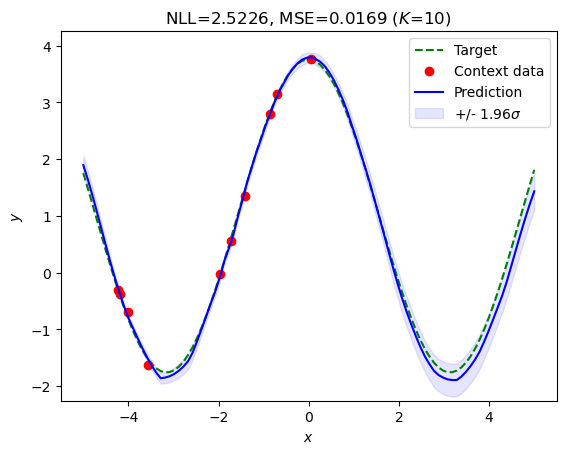

In [290]:
key, subkey = random.split(key)
plot_notebooks(subkey, part_apply_fn, kernel, kernel_self, 10, dataset_sines_infinite)

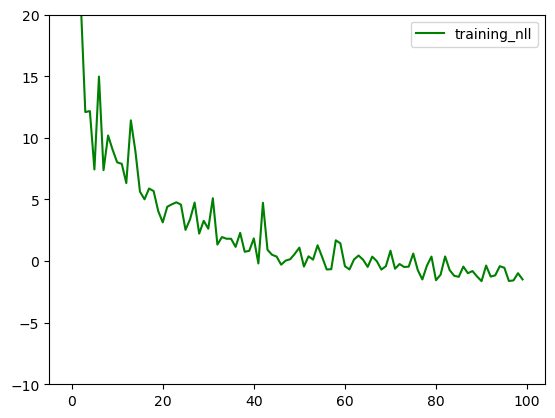

In [293]:
training_nll = [x[0] for x in output["pre_evals"]]

n_samples_training = len(training_nll)

plt.clf()
plt.plot(range(n_samples_training), training_nll, "g", label="training_nll")
plt.gca().set_ylim([-10, 20])
plt.legend()
plt.show()

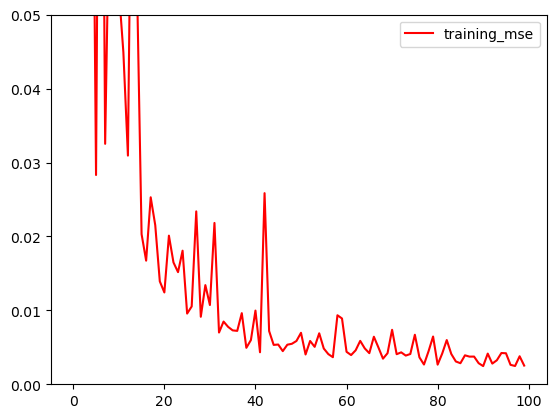

In [292]:
training_mse = [x[1] for x in output["pre_evals"]]

n_samples_training = len(training_mse)

plt.clf()
plt.plot(range(n_samples_training), training_mse, "r", label="training_mse")
plt.gca().set_ylim([0, .05])
plt.legend()
plt.show()